## Question 1

Now, bidders draw cost $c_i$ from cdf $F(\cdot)$ and get payoff $(b_i-c_i)$. In order to derive the symmetryic Nash equilibrium bidding strategy we use the revelation principle to restrict attention to direct mechanisms where participants only report $c_i$ to a bidding function $b(c)$. Now we must compute $b(c)$, the bid corresponding to $c_i$. We know that firms make expected ax ante profits

$$\pi(c, b,F(\cdot)) = (b(c) - c_i)(1-F(c))^{i-1}$$

The necessary first order condition with respect to the agent's report $c$ when $c = c_i$

$$\dfrac{\partial }{\partial c}b(c)(1-F(c))^{i-1} = \dfrac{\partial}{\partial c}c_i(1-F(c))^{i-1}  $$

Integrating from $c_i$ to $\bar{c}$  (making use of the corner condition $\bar{c} = b(\bar{c})$) we have that

$$ b(c_i)(1-F(c_i))^{i-1} - \bar{c}(1-F(\bar{c}))^{i-1} = \bar{c}(1-F(\bar{c}))^{i-1} - \int^{\bar{c}}_{c_i} c d(1-F(c))^{i-1} $$

We know that $F(\bar{c})=1$ so we can further simplify

$$ b(c_i)(1-F(c_i))^{i-1} = - \int^{\bar{c}}_{c_i} c d(1-F(c))^{i-1} $$

Integrating by parts we get that

$$ b(c_i)(1-F(c_i))^{i-1} =  c_i (1-F(c_i))^{i-1} + \int_{c_i}^{\bar{c}}(1-F(c))^{i-1} dc $$

Dividing through by $(1-F(c_i))^{i-1}$ we get the usual formula, however the markup is positive

$$b(c_i) = c_i + \int^{\bar{c}}_{c_i}\dfrac{(1-F(c))^{i-1}}{(1-F(c_i))^{i-1}} dc $$



## Question 2

### Part A - Part B

We want to estimate the individual distribution of valuations $G^i(m|b)$. To do this we non-parametrically estimate the ditribution of bids and then using the following formula from class to identify valuations.

$$v_i = b_i + \dfrac{G^i_{M|B}(b_i|b_i)}{g^i_{M|B}(b_i|b_i)} = b_i + \dfrac{G^i_{M,B}(b_i,b_i)}{g^i_{M,B}(b_i,b_i)}$$

Assuming that every auction has the same participants, we can then consistently estimate $G^i_{M,B}(b,b)$ and $g^i_{M,B}(b,b)$ using the following non parametric estimators

$$\hat{G}_{M,B}(b_{it}, b_{it}) = \dfrac{1}{T h} \sum_{1<s<T} K(\dfrac{b_{it}- b_{is} }{h}) \textbf{1}(m_{is} < b_{it})$$

$$\hat{g}_{M,B}(b_{it}, b_{it}) = \dfrac{1}{T h^2} \sum_{1<s<T} K(\dfrac{b_{it}- b_{is} }{h})  K(\dfrac{b_{it}- m_{is} }{h})$$

 Using estimated valuations, we can estimate the distribution of values non-parametrically. This estimator will use the uniform kernel and the silverman bandwith $h = 1.06 \hat{\sigma} n^{-1/5}$

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy import stats
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.optimize import fsolve

In [2]:
#load data

fpa_data = np.genfromtxt('fpa.dat', delimiter='     ')
ascending_data = np.genfromtxt('ascending_data.dat', delimiter='    ')

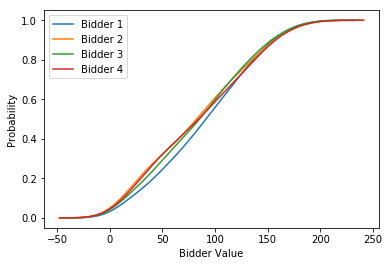

In [3]:
def apv_helper(data,i):
    """calculate the amount of shadding at each bid"""
    #calc bandwith
    data = data.copy()
    T, n = data.shape
    sigma = data.std(axis=0)[i]
    h = 1.06*sigma*T**(-1./5.) #use silverman bandwith
    
    #set up data
    support = data[:,i]
    support.sort()
    bt = np.repeat(support,T)
    bs = np.tile(data[:,i], T)
    ms = np.tile(data.max(axis=1),T)

    #caluclate formula inside the sum
    kernel1 = stats.norm.pdf( (bt - bs)/h ) #Gaussian Kernel
    kernel2 = stats.norm.pdf( (bt - ms)/h )
        
    ind = ms <= bt
    
    cdf = (kernel1*ind).reshape(T,T)
    cdf = cdf.sum(axis=1)/(T*h)

    pdf = (kernel1*kernel2).reshape(T,T)
    pdf =  pdf.sum(axis=1)/(T*h**2)
    return support + cdf/pdf
    
marginals = []
apv_values = []

for i in range(4):
    v = apv_helper(fpa_data,i) 
    apv_values.append(v)
    
    kde = sm.nonparametric.KDEUnivariate(v)
    kde.fit()
    marginals.append(kde)
    
    plt.plot(kde.support, kde.cdf, label='Bidder %s'%(i+1) )

plt.legend()
plt.xlabel('Bidder Value')
plt.ylabel('Probability')
plt.show()

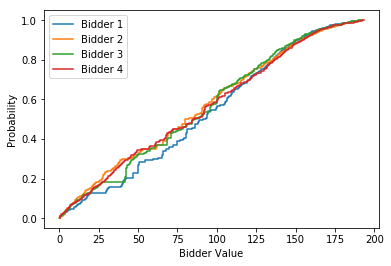

In [12]:
for i in range(4):
    v = apv_helper(fpa_data,i)
    v.sort()
    ecdf = sm.distributions.empirical_distribution.ECDF(v)
    ecdf= ecdf(v)
    plt.step(v, ecdf, label='Bidder %s'%(i+1) )

plt.legend()
plt.xlabel('Bidder Value')
plt.ylabel('Probability')
plt.show()

Technically we do not need to do density estimation for CDFs. The kernel just smooths things which is helpful for computing quantiles in the next section. We can see from the graph that the density for the private valuations are roughly the same for all of the bidders.

### Part C

I recover the quantile at each valuation by using the marginal CDF for valuations. Using the density, I try to find out which valuation corresponds to each quantile for each of the bidders. Then I use mulitvariate kernel density estimation at the valuations at each quantile.

As an alternative approach, I could find the quantiles of the marginal bidding distribution. Since valuations are increasing in bids, I could find the corresponding bid at each quantile. Then I could plug the bids at each quantile into the inverse bidding function.

In [ ]:
def enum_vectors(quantiles,n):
    """recursively enumerate all the quantiles"""
    if n == 1:
        vectors = []
        for q in quantiles:
            vectors.append([q])
        return vectors
    if n > 1:
        vectors = enum_vectors(quantiles,n-1)
        new_vectors = []
        for q in quantiles:
            for v in vectors:
                new_vectors.append(v + [q])
        return new_vectors
        

In [5]:
kde_mv = sm.nonparametric.KDEMultivariate(np.array(apv_values).transpose(),['c','c','c','c'])
quantiles = enum_vectors([.25,.75],4)


for q in quantiles:
    #work out the inverse quantiles using the estimated cdfs
    inverse_quant = []
    for i in range(4):
        index = np.where(marginals[i].cdf <= q[i])[0][-1] #find the index of quantile q
        inverse_quant.append( marginals[i].support[index] ) #return the inverse quantile
    
    #for quantile q, print the cdf
    print '==============================================================================================='
    print ' Quantile: %s | Values: %s | CDF %s'%(q, np.round(inverse_quant,3),
                                                 np.round(kde_mv.cdf(inverse_quant),3))

 Quantile: [0.25, 0.25, 0.25, 0.25] | Values: [50.564 35.811 42.813 37.614] | CDF 0.11
 Quantile: [0.75, 0.25, 0.25, 0.25] | Values: [128.414  35.811  42.813  37.614] | CDF 0.13
 Quantile: [0.25, 0.75, 0.25, 0.25] | Values: [ 50.564 125.069  42.813  37.614] | CDF 0.138
 Quantile: [0.75, 0.75, 0.25, 0.25] | Values: [128.414 125.069  42.813  37.614] | CDF 0.171
 Quantile: [0.25, 0.25, 0.75, 0.25] | Values: [ 50.564  35.811 123.745  37.614] | CDF 0.133
 Quantile: [0.75, 0.25, 0.75, 0.25] | Values: [128.414  35.811 123.745  37.614] | CDF 0.166
 Quantile: [0.25, 0.75, 0.75, 0.25] | Values: [ 50.564 125.069 123.745  37.614] | CDF 0.174
 Quantile: [0.75, 0.75, 0.75, 0.25] | Values: [128.414 125.069 123.745  37.614] | CDF 0.246
 Quantile: [0.25, 0.25, 0.25, 0.75] | Values: [ 50.564  35.811  42.813 128.64 ] | CDF 0.138
 Quantile: [0.75, 0.25, 0.25, 0.75] | Values: [128.414  35.811  42.813 128.64 ] | CDF 0.171
 Quantile: [0.25, 0.75, 0.25, 0.75] | Values: [ 50.564 125.069  42.813 128.64 ] | CDF 

### Part D

From the computer output above we can see that the joint cdf is very robust with respect to the quantiles. The order that we consider the bidders' quantitles doesn't matter or the quantiles themselves. For example, compare the (25%, 25%, 75%, 75%) quantile with the (25%, 75%, 25%, 75%). Obviously, the order has changed but the values are almost identical. This follows for other permuations of these numbers.  This would suggest (without performing a formal F test that the bidders valuations are roughly the same.

### Part E

Without re-estimating markups, I would perform an F-test to check if the different permuations of the quantiles return the same output for the cdf. In particular my null hypothesis would be that the bidders have symmetric values. For example, 

$$H_0: F_{.25,.25,.25,.75} = F_{.25,.25,.75,.25} = F_{.25,.75,.25,.25} = F_{.75,.25,.25,.25} $$

### Part F

We re-estimate the distributions with the independence assumption below. With this assumption we identify values using the inverse bidding function.

$$v_i = b_i + \dfrac{1}{I-1}\dfrac{G(b_i)}{g(v_i)}$$


The first graph shows the density of bids from the first step of the estimation procedure. Then we graph the density and CDF of valuations. There does not appear to be much difference between this and the graphs in Part B.

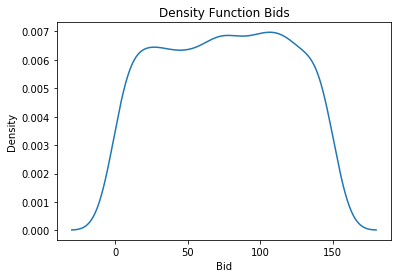

In [6]:
fpa_reshape = fpa_data.reshape(fpa_data.shape[0]*fpa_data.shape[1],)

#plot kde of bids
kde_bids = sm.nonparametric.KDEUnivariate(fpa_reshape)
kde_bids.fit()

plt.plot(kde_bids.support, kde_bids.density)
plt.title('Density Function Bids')
plt.xlabel('Bid')
plt.ylabel('Density')
plt.show()

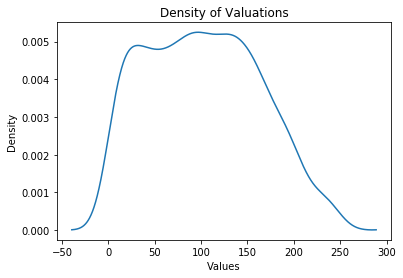

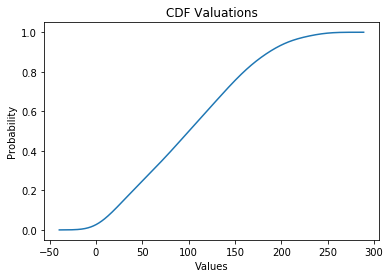

In [7]:
def est_values(data):
    """calculate values based on the formula in GPV"""

    kde = sm.nonparametric.KDEUnivariate(data)
    kde.fit()
    g = interp1d(kde.support,kde.density)
    G = interp1d(kde.support,kde.cdf)
    return data + G(data)/g(data)/(3.)



values = est_values(fpa_reshape)
kde = sm.nonparametric.KDEUnivariate(values)
kde.fit()

plt.plot(kde.support, kde.density)
plt.title('Density of Valuations')
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()

plt.plot(kde.support, kde.cdf)
plt.title('CDF Valuations')
plt.xlabel('Values')
plt.ylabel('Probability')
plt.show()

## Question 3

In [10]:
from scipy.optimize import fsolve
ascending_data = np.genfromtxt('ascending_data.dat', delimiter='    ')

def english_helper(data):
    #calculate empirical cdf
    data = data.copy()
    ns = np.arange( data[:,0].min(),data[:,0].max()+1,1)

    cdfs = []
    supps = []
    for n in ns:
        support = data[:,1][data[:,0]==n]
        support, bids = support.copy(), support.copy()
        support.sort()
        supps.append(support)
        
        T = support.shape[0]

        bt = np.repeat(support,T)
        bs = np.tile(bids, T)

        pdf = 1.*(bt >= bs)
        pdf = pdf.reshape(T,T)
        pdf =  pdf.sum(axis=1)/(T)
        cdfs.append(pdf)
        
    return ns, supps, cdfs


def calc_phi(cdf,n):
    integral = lambda t: n*(n-1)*((1-t)*t**(n-2))
    new_cdf = np.array([])
    for F in cdf:
        phi = lambda h: F - quad(integral, 0, h)[0]
        result = fsolve(phi,F)
        new_cdf = np.concatenate((new_cdf, result))
    return new_cdf

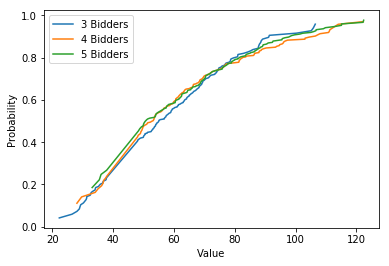

In [11]:
#plot the values implied by the order statistic

ascending_data = np.genfromtxt('ascending_data.dat', delimiter='    ')
ns, supps, cdfs = english_helper(ascending_data)
for i in range(int(ns[-1] - ns[0]+1)):
    value = calc_phi(cdfs[i], ns[i])
    #some weird numerical errors going on with the quadrature, so I cleaned up graph
    plt.plot(supps[i][(value<1) & (value >0) & ((supps[i] < 38) | (supps[i] > 48)) ],
             value[(value<1) & (value >0) & ((supps[i] < 38) | (supps[i] > 48)) ]
             , label = '%s Bidders'%int(ns[i]))
    
plt.xlabel('Value')
plt.ylabel('Probability')
plt.legend()
plt.show()